In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.model_selection import ParameterGrid

from recsys4daos.models import NLPSimilarity
from recsys4daos.utils import Timer
from recsys4daos.datasets import to_microsoft
from recsys4daos.evaluation import calculate_all_metrics
from recsys4daos.model_selection import cvtt_open, explore_hparams

import paths

import seaborn as sns
sns.set_theme()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/home/daviddavo/recsys4daos/.direnv/python-3.11/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Parameters

In [2]:
# Dataset config
ORG_NAME = 'Decentraland'

# Evaluation
K_RECOMMENDATIONS: list[int] = [1,3,5,10,15,100]
SPLITS_FREQ: str = 'W-THU' # split weekly
SPLITS_NORMALIZE = True # Wether or not to move everything to 00:00
LAST_FOLDS = 10 # Use just last 10 splits
LAST_FOLD_DATE_STR: str = None

# Search space config
WINDOW_SIZES = ['7d', '14d', '21d', '30d', '60d', '90d', '10YE']
MODEL_NAMES = [
    'all-mpnet-base-v2', # The one used in sbert's examples
    'all-distilroberta-v1',
    'all-MiniLM-L12-v2',
    'all-MiniLM-L6-v2',
]

OPTIM_METRIC = 'map@10'

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
ORG_NAME = "dxDAO - xDXdao"
SPLITS_FREQ = "W-THU"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2022-05-05"


In [4]:
EMBEDDINGS_CACHE = Path(paths.DEFAULT_CACHE_PATH) / 'pln-embeddings'

# Load the dataset

In [5]:
dfp = paths.load_proposals(ORG_NAME, text=True)
dfv = paths.load_votes(ORG_NAME)

print(dfp.info())
print(dfv.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 2356 non-null   object        
 1   author             2356 non-null   object        
 2   date               2356 non-null   datetime64[us]
 3   start              2356 non-null   datetime64[us]
 4   end                2323 non-null   datetime64[us]
 5   platform_proposal  2356 non-null   object        
 6   title              2321 non-null   object        
 7   description        2321 non-null   object        
dtypes: datetime64[us](3), object(5)
memory usage: 147.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8479 entries, 0 to 8478
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        8479 non-null   object        
 1   proposal  8479 non-null   obj

In [6]:
df = to_microsoft(dfv)
df

,userID,itemID,timestamp,rating
0,0x166cea845ade3f3b40ea68045d699dee5a645905,82f205b3-1f75-5da5-973a-fc2e324d8719,2019-07-14 19:50:09,1
1,0x166cea845ade3f3b40ea68045d699dee5a645905,b1f193e6-cf73-5a7a-85f3-a84d95c08b97,2019-07-14 19:51:24,1
2,0xe858a4bf603995a9156edbd25ff06269d997839e,b1f193e6-cf73-5a7a-85f3-a84d95c08b97,2019-07-14 22:24:38,1
3,0xe858a4bf603995a9156edbd25ff06269d997839e,398d685b-8c4f-5b7d-a7d6-86f1fc78efa4,2019-07-14 22:29:44,1
4,0xe858a4bf603995a9156edbd25ff06269d997839e,cb124ba8-a044-5790-8da9-43129a92c1f5,2019-07-14 22:31:43,1
...,...,...,...,...
8474,0x583acc79585d3cb195ea8125f6f80ad459b46313,783c82b4-a78e-58ee-972e-08a8d5677735,2023-04-08 07:38:59,1
8475,0x7e72cfd9a36517435dc1ca7f9451eccbc973111e,783c82b4-a78e-58ee-972e-08a8d5677735,2023-04-08 13:45:11,1
8476,0x3111327edd38890c3fe564afd96b4c73e8101747,783c82b4-a78e-58ee-972e-08a8d5677735,2023-04-08 18:13:23,1
8477,0x759a2169da1b826f795a00a9ab5f29f9ca39e48a,783c82b4-a78e-58ee-972e-08a8d5677735,2023-04-09 08:40:35,1


## Split in folds

In [7]:
all_folds = { f.end:f for f in cvtt_open(
    df, SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', last_fold=LAST_FOLD_DATE_STR,
)}
last_folds_idx = list(all_folds.keys())[-LAST_FOLDS:]
last_folds_idx

[Timestamp('2022-03-03 00:00:00'),
 Timestamp('2022-03-10 00:00:00'),
 Timestamp('2022-03-17 00:00:00'),
 Timestamp('2022-03-24 00:00:00'),
 Timestamp('2022-03-31 00:00:00'),
 Timestamp('2022-04-07 00:00:00'),
 Timestamp('2022-04-14 00:00:00'),
 Timestamp('2022-04-21 00:00:00'),
 Timestamp('2022-04-28 00:00:00'),
 Timestamp('2022-05-05 00:00:00')]

# Similarity PLN

In [8]:
def testHParamsPLNSimilarity(fold, window_size, model_name):
    f = all_folds[fold]
    
    model = NLPSimilarity(dfp, EMBEDDINGS_CACHE, model_name=model_name)

    offset = pd.tseries.frequencies.to_offset(window_size)
    train = f.train[f.train['timestamp'] > (f.end - offset)]

    with Timer() as t_fit:
        model.fit(train)

    with Timer() as t_rec:
        # Truncate the top_k
        top_k = max(K_RECOMMENDATIONS)
        users = np.intersect1d(f.test['userID'].unique(), train['userID'].unique())
        recs = model.recommend_k_items(users, top_k=min(len(f.open_proposals), top_k), recommend_from=f.open_proposals)
    
    return {
        'time_train': t_fit.time,
        'time_rec': t_rec.time,
        'rec_users': len(users),
        **calculate_all_metrics(f.test, recs, K_RECOMMENDATIONS),
    }

# testHParamsPLNSimilarity(last_folds_idx[0], '14D', MODEL_NAMES[0])

In [9]:
# Populate the cache of embeddings for each model
from recsys4daos.models.nlp import NLPModel

for m in MODEL_NAMES:
    NLPModel(dfp, EMBEDDINGS_CACHE, model_name=m).fit()

In [10]:
results = explore_hparams(
    testHParamsPLNSimilarity,
    ParameterGrid({
        'fold': last_folds_idx,
        'model_name': MODEL_NAMES,
        'window_size': WINDOW_SIZES,
    }),
    paths.hparams_progress('pln-similarity', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE),
)
mdf = pd.DataFrame(results)
mdf

Restored checkpoint from ../.cache/dxDAO - xDXdao/hparams-pln-similarity_W-THU_normalize.pkl with 280 results


  0%|          | 0/280 [00:00<?, ?it/s]

,fold,model_name,window_size,time_train,time_rec,rec_users,precision@1,precision@3,precision@5,precision@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
0,2022-03-03,all-mpnet-base-v2,7d,0.233121,0.001412,8,0.125000,0.250000,0.250000,0.287500,...,0.875000,0.968750,1.0,0.333333,0.258333,0.339583,0.402083,0.402083,0.402083,0.136380
1,2022-03-03,all-mpnet-base-v2,14d,0.081994,0.001382,8,0.250000,0.250000,0.275000,0.287500,...,0.875000,0.968750,1.0,0.229167,0.258333,0.339583,0.402083,0.402083,0.402083,0.136285
2,2022-03-03,all-mpnet-base-v2,21d,0.234851,0.001366,9,0.333333,0.259259,0.266667,0.266667,...,0.805556,0.944444,1.0,0.236111,0.256667,0.321667,0.371667,0.371667,0.371667,0.133622
3,2022-03-03,all-mpnet-base-v2,30d,0.081662,0.001388,9,0.555556,0.259259,0.266667,0.288889,...,0.833333,0.944444,1.0,0.381667,0.380556,0.434722,0.476389,0.476389,0.476389,0.133229
4,2022-03-03,all-mpnet-base-v2,60d,0.234013,0.001429,9,0.444444,0.259259,0.288889,0.266667,...,0.768519,0.916667,1.0,0.414583,0.380556,0.434722,0.476389,0.476389,0.476389,0.133384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,2022-05-05,all-MiniLM-L6-v2,21d,0.068895,0.001307,8,0.000000,0.083333,0.100000,0.200000,...,0.566667,0.875000,1.0,0.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.127272
276,2022-05-05,all-MiniLM-L6-v2,30d,0.225345,0.001398,8,0.000000,0.041667,0.150000,0.187500,...,0.545833,0.875000,1.0,0.000000,NaN,0.183333,0.183333,0.183333,0.183333,0.128524
277,2022-05-05,all-MiniLM-L6-v2,60d,0.075780,0.001421,10,0.100000,0.133333,0.200000,0.220000,...,0.663333,0.830000,1.0,0.200000,0.244444,0.316667,0.316667,0.316667,0.316667,0.134819
278,2022-05-05,all-MiniLM-L6-v2,90d,0.229046,0.001359,10,0.200000,0.200000,0.160000,0.230000,...,0.683333,0.850000,1.0,0.266667,0.377778,0.377778,0.325000,0.325000,0.325000,0.133429


<Axes: xlabel='window_size', ylabel='map@10'>

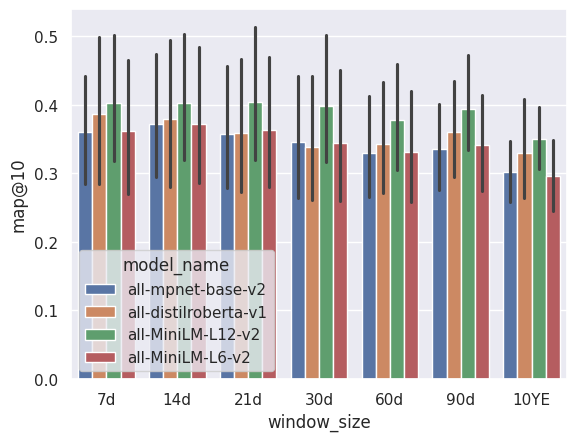

In [11]:
sns.barplot(mdf, x='window_size', y=OPTIM_METRIC, hue='model_name')

## Best overall hparams

In [12]:
display_columns = ['time_train'] + [ c for c in mdf.columns if c.endswith('@5') or c.endswith('@10') or c.endswith('@100') ]
hparam_cols = ['window_size', 'model_name']
overall_hparams = mdf[mdf['fold'] > last_folds_idx[0]].groupby(hparam_cols).mean().sort_values(OPTIM_METRIC, ascending=False)
overall_hparams[display_columns]

time_train  precision@5  precision@10  \
window_size model_name                                                    
21d         all-MiniLM-L12-v2       0.156760     0.267778      0.232096   
7d          all-MiniLM-L12-v2       0.154775     0.266582      0.246507   
14d         all-MiniLM-L12-v2       0.156132     0.268765      0.240303   
7d          all-distilroberta-v1    0.152420     0.265236      0.240404   
90d         all-MiniLM-L12-v2       0.161159     0.263654      0.223880   
30d         all-MiniLM-L12-v2       0.158152     0.260210      0.218048   
14d         all-distilroberta-v1    0.204497     0.252250      0.227803   
            all-MiniLM-L6-v2        0.157253     0.234355      0.232222   
60d         all-MiniLM-L12-v2       0.176127     0.256036      0.217318   
14d         all-mpnet-base-v2       0.169507     0.260471      0.248897   
21d         all-MiniLM-L6-v2        0.139675     0.220527      0.217626   
7d          all-MiniLM-L6-v2        0.188445     0.228648      0.234919   
21d         all-distilroberta-v1    0.154075     0.242710      0.215222   
7d          all-mpnet-base-v2       0.185521     0.255976      0.249313   
90d         all-distilroberta-v1    0.177256     0.251231      0.208971   
21d         all-mpnet-base-v2       0.169864     0.253474      0.226815   
30d         all-MiniLM-L6-v2        0.174403     0.214806      0.212066   
90d         all-MiniLM-L6-v2        0.177978     0.240364      0.216983   
10YE        all-MiniLM-L12-v2       0.206231     0.256544      0.202500   
60d         all-distilroberta-v1    0.174488     0.230299      0.203962   
30d         all-distilroberta-v1    0.189905     0.236336      0.207549   
            all-mpnet-base-v2       0.190122     0.235564      0.220668   
10YE        all-distilroberta-v1    0.242475     0.235286      0.197794   
90d         all-mpnet-base-v2       0.176242     0.247915      0.216539   
60d         all-MiniLM-L6-v2        0.158656     0.218134      0.207954   
            all-mpnet-base-v2       0.158084     0.230140      0.217260   
10YE        all-MiniLM-L6-v2        0.174160     0.231674      0.207922   
            all-mpnet-base-v2       0.241173     0.240460      0.207600   

                                  precision@100    ndcg@5   ndcg@10  ndcg@100  \
window_size model_name                                                          
21d         all-MiniLM-L12-v2          0.031928  0.387712  0.476230  0.551496   
7d          all-MiniLM-L12-v2          0.034764  0.325404  0.417102  0.481713   
14d         all-MiniLM-L12-v2          0.033042  0.356871  0.445265  0.517845   
7d          all-distilroberta-v1       0.034764  0.329176  0.404935  0.478103   
90d         all-MiniLM-L12-v2          0.030516  0.422068  0.531675  0.613487   
30d         all-MiniLM-L12-v2          0.031747  0.381070  0.463144  0.555429   
14d         all-distilroberta-v1       0.033042  0.340071  0.429700  0.504511   
            all-MiniLM-L6-v2           0.033042  0.327477  0.425030  0.499952   
60d         all-MiniLM-L12-v2          0.030567  0.397097  0.502310  0.595303   
14d         all-mpnet-base-v2          0.033042  0.325753  0.430205  0.487059   
21d         all-MiniLM-L6-v2           0.031928  0.336798  0.434719  0.523873   
7d          all-MiniLM-L6-v2           0.034764  0.290001  0.385386  0.462772   
21d         all-distilroberta-v1       0.031928  0.343422  0.433174  0.517714   
7d          all-mpnet-base-v2          0.034764  0.294470  0.393577  0.453423   
90d         all-distilroberta-v1       0.030516  0.402375  0.495921  0.593471   
21d         all-mpnet-base-v2          0.031928  0.338919  0.432175  0.507583   
30d         all-MiniLM-L6-v2           0.031747  0.312950  0.418564  0.515655   
90d         all-MiniLM-L6-v2           0.030516  0.372357  0.486499  0.570957   
10YE        all-MiniLM-L12-v2          0.030453  0.399009  0.477762  0.584359   
60d         all-distilroberta-v1       0.030567  0.364444  0.464497  0.571122   
3

In [13]:
best_avg_hparams = mdf.set_index(hparam_cols).loc[overall_hparams.iloc[0].name].reset_index().set_index(['fold', *hparam_cols])
paths.save_model_results(best_avg_hparams, 'plnsim-best-avg', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
best_avg_hparams

Saved dataframe into /home/daviddavo/recsys4daos/data/output/dxDAO - xDXdao/models/plnsim-best-avg_W-THU_normalize.parquet


/tmp/ipykernel_3821657/971293119.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  best_avg_hparams = mdf.set_index(hparam_cols).loc[overall_hparams.iloc[0].name].reset_index().set_index(['fold', *hparam_cols])


,,,time_train,time_rec,rec_users,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
fold,window_size,model_name,,,,,,,,,,,,,,,,,,,,,
2022-03-03,21d,all-MiniLM-L12-v2,0.070495,0.001343,9,0.333333,0.296296,0.288889,0.255556,0.229630,0.035556,0.333333,...,0.722222,0.972222,1.0,0.219444,0.380000,0.470000,0.520000,0.520000,0.520000,0.132545
2022-03-10,21d,all-MiniLM-L12-v2,0.221972,0.001348,10,0.400000,0.266667,0.300000,0.310000,0.320000,0.055000,0.363636,...,0.639683,0.904762,1.0,0.128472,0.256944,0.314059,0.431122,0.431122,0.431122,0.137038
2022-03-17,21d,all-MiniLM-L12-v2,0.074208,0.001411,10,0.600000,0.400000,0.300000,0.300000,0.266667,0.041000,0.500000,...,0.643095,0.983333,1.0,0.212897,0.335516,0.410913,0.500198,0.500198,0.500198,0.136281
2022-03-24,21d,all-MiniLM-L12-v2,0.225354,0.001414,22,0.818182,0.409091,0.300000,0.186364,0.145455,0.024545,0.692308,...,0.859848,0.915530,1.0,0.777315,0.774167,0.813333,0.842500,0.842500,0.842500,0.142151
2022-03-31,21d,all-MiniLM-L12-v2,0.225818,0.001358,9,0.333333,0.296296,0.311111,0.222222,0.192593,0.028889,0.300000,...,0.714815,1.000000,1.0,0.344444,0.359524,0.423810,0.423810,0.423810,0.423810,0.134203
2022-04-07,21d,all-MiniLM-L12-v2,0.073992,0.001388,12,0.500000,0.361111,0.316667,0.283333,0.250000,0.041667,0.461538,...,0.739352,0.923148,1.0,0.274074,0.369136,0.444444,0.484568,0.503086,0.503086,0.136212
2022-04-14,21d,all-MiniLM-L12-v2,0.225654,0.001365,10,0.300000,0.200000,0.160000,0.130000,0.100000,0.015000,0.272727,...,0.850000,1.000000,1.0,0.733333,0.800000,0.866667,0.866667,0.866667,0.866667,0.135977
2022-04-21,21d,all-MiniLM-L12-v2,0.070403,0.001354,12,0.166667,0.194444,0.216667,0.166667,0.133333,0.020000,0.142857,...,0.900000,1.000000,1.0,0.600000,0.511111,0.577778,0.577778,0.577778,0.577778,0.135858
2022-04-28,21d,all-MiniLM-L12-v2,0.222243,0.001334,9,0.555556,0.370370,0.355556,0.277778,0.200000,0.030000,0.454545,...,0.971781,1.000000,1.0,0.450794,0.525132,0.585979,0.665344,0.665344,0.665344,0.134690


## best hparams by fold

In [14]:
print("Best hyperparams by fold", OPTIM_METRIC)
best_hparams = mdf.sort_values(OPTIM_METRIC,ascending=False).drop_duplicates(['fold'], keep='first').sort_values('fold').set_index(['fold', 'model_name', 'window_size'])
paths.save_model_results(best_hparams, 'plnsim-best-val', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
best_hparams[display_columns]

Best hyperparams by fold map@10
Saved dataframe into /home/daviddavo/recsys4daos/data/output/dxDAO - xDXdao/models/plnsim-best-val_W-THU_normalize.parquet


,,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
fold,model_name,window_size,,,,,,,,,,,,,,,,
2022-03-03,all-MiniLM-L12-v2,30d,0.218302,0.311111,0.288889,0.035556,0.436123,0.599529,0.666237,0.348704,0.461614,0.505816,0.427778,0.824074,1.0,0.544444,0.586111,0.586111
2022-03-10,all-MiniLM-L12-v2,7d,0.220735,0.350000,0.362500,0.060000,0.288281,0.370322,0.494938,0.256979,0.334747,0.466329,0.333829,0.625992,1.0,0.298186,0.413265,0.413265
2022-03-17,all-MiniLM-L12-v2,90d,0.074240,0.333333,0.266667,0.037500,0.466654,0.544759,0.654403,0.371806,0.408553,0.479693,0.436111,0.716468,1.0,0.533333,0.592007,0.592007
2022-03-24,all-MiniLM-L12-v2,21d,0.225354,0.300000,0.186364,0.024545,0.685775,0.700803,0.745988,0.764545,0.779078,0.812342,0.800000,0.859848,1.0,0.813333,0.842500,0.842500
2022-03-31,all-distilroberta-v1,90d,0.092801,0.320000,0.250000,0.027000,0.474242,0.617500,0.636126,0.351417,0.457171,0.472777,0.625000,0.960000,1.0,0.597222,0.597222,0.597222
2022-04-07,all-MiniLM-L12-v2,30d,0.226863,0.316667,0.266667,0.041667,0.417580,0.506421,0.627575,0.353333,0.401381,0.487226,0.354167,0.656019,1.0,0.444444,0.484568,0.493827
2022-04-14,all-MiniLM-L12-v2,7d,0.223502,0.200000,0.144444,0.015556,0.411206,0.501810,0.525079,0.451111,0.513148,0.521085,0.588889,0.888889,1.0,0.950000,0.950000,0.950000
2022-04-21,all-distilroberta-v1,14d,0.237655,0.200000,0.150000,0.020000,0.421818,0.473225,0.525972,0.392130,0.419938,0.455745,0.697222,0.830556,1.0,0.673333,0.673333,0.673333
2022-04-28,all-distilroberta-v1,7d,0.084193,0.375000,0.287500,0.032500,0.502168,0.562739,0.582423,0.615833,0.664757,0.696277,0.671627,0.950397,1.0,0.645503,0.724868,0.724868


In [15]:
best_hparams.describe()[display_columns]

,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000
mean,0.185246,0.298611,0.244303,0.032732,0.445365,0.535685,0.604919,0.416552,0.478470,0.530343,0.532129,0.799891,1.0,0.597758,0.634165,0.635091
std,0.070730,0.058136,0.067575,0.012522,0.104720,0.091426,0.076750,0.158998,0.141390,0.124977,0.164174,0.121127,0.0,0.186540,0.167995,0.167102
min,0.074240,0.200000,0.144444,0.015556,0.288281,0.370322,0.494938,0.256979,0.334747,0.406138,0.333829,0.625992,1.0,0.298186,0.413265,0.413265
25%,0.124176,0.285000,0.199773,0.025159,0.412799,0.485256,0.540084,0.349382,0.403174,0.467941,0.396944,0.694117,1.0,0.491667,0.509954,0.516898
50%,0.222119,0.313889,0.258333,0.032750,0.428970,0.525590,0.609014,0.362569,0.438554,0.483460,0.512500,0.827315,1.0,0.570833,0.594615,0.594615
75%,0.226486,0.330000,0.282292,0.037014,0.472345,0.590332,0.649833,0.436366,0.500265,0.517267,0.659970,0.881629,1.0,0.666376,0.711984,0.711984
max,0.248817,0.375000,0.362500,0.060000,0.685775,0.700803,0.745988,0.764545,0.779078,0.812342,0.800000,0.960000,1.0,0.950000,0.950000,0.950000


### Results of using best hparams on next fold

In [16]:
next_hparams_idx = best_hparams.index.to_frame(False)
next_hparams_idx['fold'] = next_hparams_idx['fold'].shift(-1)
next_hparams_idx = next_hparams_idx.dropna()
assert len(next_hparams_idx) == len(best_hparams)-1
next_hparams = mdf.set_index(['fold', 'model_name', 'window_size']).loc[pd.MultiIndex.from_frame(next_hparams_idx)]
paths.save_model_results(next_hparams, 'plnsim-best-test', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
next_hparams[display_columns]

Saved dataframe into /home/daviddavo/recsys4daos/data/output/dxDAO - xDXdao/models/plnsim-best-test_W-THU_normalize.parquet


,,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
fold,model_name,window_size,,,,,,,,,,,,,,,,
2022-03-10,all-MiniLM-L12-v2,30d,0.071525,0.320000,0.310000,0.055000,0.319918,0.421653,0.578932,0.235667,0.284109,0.422261,0.290675,0.639683,1.0,0.367630,0.466837,0.466837
2022-03-17,all-MiniLM-L12-v2,7d,0.068715,0.350000,0.262500,0.048750,0.279466,0.287891,0.437583,0.310833,0.304209,0.443074,0.302976,0.430655,1.0,0.384762,0.463333,0.463333
2022-03-24,all-MiniLM-L12-v2,90d,0.230774,0.296000,0.196000,0.024800,0.712626,0.755507,0.799998,0.675867,0.706356,0.737616,0.752333,0.876667,1.0,0.784524,0.812302,0.812302
2022-03-31,all-MiniLM-L12-v2,21d,0.225818,0.311111,0.222222,0.028889,0.376078,0.462537,0.549026,0.301296,0.367654,0.419595,0.487037,0.714815,1.0,0.423810,0.423810,0.423810
2022-04-07,all-distilroberta-v1,90d,0.252343,0.292308,0.230769,0.039231,0.390987,0.452616,0.598517,0.279103,0.311786,0.403475,0.431197,0.609829,1.0,0.419444,0.464583,0.485417
2022-04-14,all-MiniLM-L12-v2,30d,0.074398,0.140000,0.100000,0.015000,0.294822,0.347469,0.459416,0.263333,0.304444,0.344396,0.410000,0.550000,1.0,0.700000,0.700000,0.700000
2022-04-21,all-MiniLM-L12-v2,7d,0.069833,0.150000,0.200000,0.022500,0.123963,0.250829,0.269744,0.144167,0.262421,0.278046,0.304167,0.895833,1.0,0.600000,0.600000,0.600000
2022-04-28,all-distilroberta-v1,14d,0.239883,0.400000,0.312500,0.032500,0.477260,0.536912,0.542872,0.563750,0.610115,0.621479,0.689484,0.986111,1.0,0.502646,0.582011,0.582011
2022-05-05,all-distilroberta-v1,7d,0.235078,0.175000,0.212500,0.031250,0.209803,0.324670,0.430467,0.200000,0.291229,0.358827,0.300000,0.591667,1.0,0.516667,0.558333,0.558333


In [17]:
next_hparams.describe()[display_columns]

,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.0,9.000000,9.000000,9.000000
mean,0.163152,0.270491,0.227388,0.033102,0.353880,0.426676,0.518506,0.330446,0.382480,0.447641,0.440874,0.699473,1.0,0.522165,0.563468,0.565782
std,0.087618,0.092862,0.064734,0.012711,0.169407,0.153756,0.145984,0.174220,0.160688,0.143622,0.173962,0.183776,0.0,0.145736,0.127921,0.126084
min,0.068715,0.140000,0.100000,0.015000,0.123963,0.250829,0.269744,0.144167,0.262421,0.278046,0.290675,0.430655,1.0,0.367630,0.423810,0.423810
25%,0.071525,0.175000,0.200000,0.024800,0.279466,0.324670,0.437583,0.235667,0.291229,0.358827,0.302976,0.591667,1.0,0.419444,0.464583,0.466837
50%,0.225818,0.296000,0.222222,0.031250,0.319918,0.421653,0.542872,0.279103,0.304444,0.419595,0.410000,0.639683,1.0,0.502646,0.558333,0.558333
75%,0.235078,0.320000,0.262500,0.039231,0.390987,0.462537,0.578932,0.310833,0.367654,0.443074,0.487037,0.876667,1.0,0.600000,0.600000,0.600000
max,0.252343,0.400000,0.312500,0.055000,0.712626,0.755507,0.799998,0.675867,0.706356,0.737616,0.752333,0.986111,1.0,0.784524,0.812302,0.812302
